In [1]:
import os
import zipfile
from google.colab import drive

dataset_4 = True

if dataset_4:

  !rm /content/download
  !rm -r /content/imagedb/
  !rm -r /content/imagedb_test
  !wget https://vc.ee.duth.gr:6960/index.php/s/wlnkxtlGmqBeATC/download
  local_zip = '/content/download'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/content')
  zip_ref.close()

  train_dir = '/content/imagedb'
  test_dir = '/content/imagedb_test'

else:
  drive.mount('/content/drive')
  local_zip = '/content/drive/MyDrive/caltech.zip'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/content')
  zip_ref.close()
  train_dir = '/content/caltech/imagedb'
  test_dir = '/content/caltech/imagedb_test'

rm: cannot remove '/content/download': No such file or directory
rm: cannot remove '/content/imagedb/': No such file or directory
rm: cannot remove '/content/imagedb_test': No such file or directory
--2023-01-30 16:01:39--  https://vc.ee.duth.gr:6960/index.php/s/wlnkxtlGmqBeATC/download
Resolving vc.ee.duth.gr (vc.ee.duth.gr)... 83.212.140.54
Connecting to vc.ee.duth.gr (vc.ee.duth.gr)|83.212.140.54|:6960... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181682323 (173M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 173.27M  9.87MB/s    in 18s     

2023-01-30 16:02:00 (9.42 MB/s) - ‘download’ saved [181682323/181682323]



In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))

modelVaia = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [3]:
# Freeze the layers except the last 4 layers
for layer in modelVaia.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in modelVaia.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f578b5d2280> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f578c904040> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f57281f2130> False
<keras.layers.core.activation.Activation object at 0x7f57281685b0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5728168dc0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f5728168a60> False
<keras.layers.core.activation.Activation object at 0x7f572009a580> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f57200a5ee0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f57200aa760> False
<keras.layers.core.activation.Activation object at 0x7f57200a59d0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f5728168250> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5728168730> False
<keras.layers.normalization.batch_norm

In [4]:
from keras import models
from keras import layers
from keras import optimizers
import tensorflow as tf

 
# Create the model
model = models.Sequential()
 
# Add the inception convolutional base model
model.add(modelVaia)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
if dataset_4:
 model.add(layers.Dense(34, activation='softmax'))
else:
  model.add(layers.Dense(5, activation='softmax')) 
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 2048)              268437504 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              5

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input


train_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)
# train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2,zoom_range=0.2,rotation_range=15,horizontal_flip=True)
# --------------------
# Flow training images in batches of 50 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=50,
                                                    class_mode='categorical',
                                                    # color_mode='grayscale',
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    subset='training', seed=1)     
# --------------------
# Flow validation images in batches of 50 using test_datagen generator
# --------------------
validation_generator =  train_datagen.flow_from_directory(train_dir,
                                                        batch_size=50,
                                                        class_mode='categorical',
                                                        #  color_mode='grayscale',
                                                         target_size=(224,224),
                                                        subset='validation', seed=1) 

Found 2457 images belonging to 34 classes.
Found 599 images belonging to 34 classes.


In [6]:
# Compile the model
from keras import models
from keras import layers
from keras import optimizers
import datetime

batch_size = 50
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam_v2.Adam(learning_rate=1e-4),
              metrics=['acc'])

callbacks = []

reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=4,min_lr=1e-6)

early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
callbacks.append(early_stop_callback)
callbacks.append(reduce_lr)
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=80,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# # Save the model
model.save('VaiaNet')

<ipython-input-6-ebcb52d7ca93>:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/80
49/49 [==============================] - 35s 428ms/step - loss: 3.1162 - acc: 0.2312 - val_loss: 1.6929 - val_acc: 0.5726
Epoch 2/80
49/49 [==============================] - 16s 322ms/step - loss: 1.9445 - acc: 0.4831 - val_loss: 1.1531 - val_acc: 0.6778
Epoch 3/80
49/49 [==============================] - 16s 330ms/step - loss: 1.4263 - acc: 0.6044 - val_loss: 0.9474 - val_acc: 0.7145
Epoch 4/80
49/49 [==============================] - 16s 321ms/step - loss: 1.1105 - acc: 0.6862 - val_loss: 0.6780 - val_acc: 0.8080
Epoch 5/80
49/49 [==============================] - 16s 316ms/step - loss: 0.8439 - acc: 0.7505 - val_loss: 0.5754 - val_acc: 0.8314
Epoch 6/80
49/49 [==============================] - 16s 318ms/step - loss: 0.6212 - acc: 0.8185 - val_loss: 0.4782 - val_acc: 0.8464
Epoch 7/80
49/49 [==============================] - 16s 323ms/step - loss: 0.4816 - acc: 0.8551 - val_loss: 0.3771 - val_acc: 0.8698
Epoch 8/80
49/49 [==============================] - 16s 324ms/step - 

In [7]:
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

# --------------------
# Flow validation images in batches of 50 using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                        batch_size=50,
                                                        class_mode='categorical',
                                                        #  color_mode='grayscale',
                                                         target_size=(224,224)) 
loss, acc = model.evaluate(test_generator)

Found 2149 images belonging to 34 classes.
43/43 [==============================] - 9s 208ms/step - loss: 0.5917 - acc: 0.9055


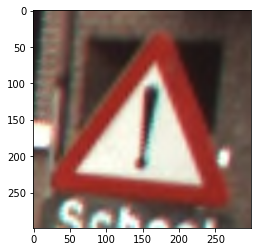

1/1 [==============================] - 1s 1s/step



['00004', '00005', '00007', '00008', '00010', '00012', '00013', '00017', '00018', '00019', '00021', '00027', '00028', '00029', '00030', '00031', '00032', '00034', '00035', '00037', '00038', '00039', '00041', '00042', '00043', '00045', '00047', '00051', '00053', '00054', '00056', '00057', '00058', '00059']



Softmax Output: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 6.8331374e-14 0.0000000e+00 0.0000000e+00 8.5060042e-33
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]



/content/imagedb_test/00013/00118_00000.ppm is a 00038





In [12]:
from keras.utils import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

if dataset_4:
  path = '/content/imagedb_test/00013/00118_00000.ppm'
else:
  path = '/content/caltech/imagedb_test/178.school-bus/178_0090.jpg'


img = load_img(path, target_size=(224, 224), grayscale=False, interpolation='bilinear')
plt.imshow(img, cmap='gray')
plt.show()

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
model = tf.keras.models.load_model('VaiaNet')
classes_pred = model.predict(x)
if dataset_4:
  classes = ['00004','00005','00007','00008','00010','00012','00013','00017','00018','00019','00021','00027','00028','00029','00030','00031','00032',
             '00034','00035','00037','00038','00039','00041','00042','00043','00045','00047','00051','00053','00054','00056','00057','00058','00059']
else:
  classes = ['145.motorbikes-101','178.school-bus','224.touring-bike','251.airplanes-101','252.car-side-101']
print(f'\n\n\n{classes}')
print(f'\n\n\nSoftmax Output: {classes_pred}')
print(f'\n\n\n{path} is a {classes[classes_pred.argmax()]}\n\n\n')
